In [4]:
from ultralytics import YOLO

# Берем модель Yolo и тренируем ее на coco
# Load a model
model = YOLO("yolov8n.yaml")  # build a new model from scratch
model = YOLO("yolov8n.pt")  # load a pretrained model (recommended for training)

# Use the model
results = model.train(data="coco128.yaml", epochs=3)  # train the model
results = model.val()  # evaluate model performance on the validation set


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.Conv                  [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.Conv                  [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.C2f                   [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.Conv                  [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.C2f                   [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.Conv                  [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.C2f                   [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.Conv                  [128

In [5]:
import matplotlib
%matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import os
from PIL import Image
import cv2
import numpy as np
import pandas as pd

Using matplotlib backend: TkAgg


In [6]:
def show_image_by_url(url, w=15, h=15):
    image = cv2.imread(url)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # преобразование порядка цветов
    plt.figure(figsize=(w, h))
    plt.grid(False)
    plt.imshow(image)
    plt.show()

In [7]:
def result_and_show(url, model):
    import os
    from PIL import Image
    import cv2
    import numpy as np
    results = model(url)
    image = cv2.imread(url)
    color = (0, 255, 0)
    thickness = 2
    # извлечение координат боксов
    boxes = results[0].boxes.boxes

    # отображение боксов на изображении
    for box in boxes:
        x1, y1, x2, y2, conf, cls = box.tolist()
        if conf > 0.5 and cls == 0:
            cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), color, thickness)

    # отображение изображения с боксами
    cv2.imwrite(f"{url}_bbox.jpg", image)
    show_image_by_url(f"{url}_bbox.jpg")

Ultralytics YOLOv8.0.45 🚀 Python-3.9.12 torch-1.13.1+cu117 CUDA:0 (NVIDIA GeForce RTX 4080, 16076MiB)

image 1/1 /home/gordondalos/Документы/Университет/ai-universitet/practica/photo_2023-02-19_20-05-10.jpg: 640x640 4 persons, 29.2ms
Speed: 0.6ms preprocess, 29.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


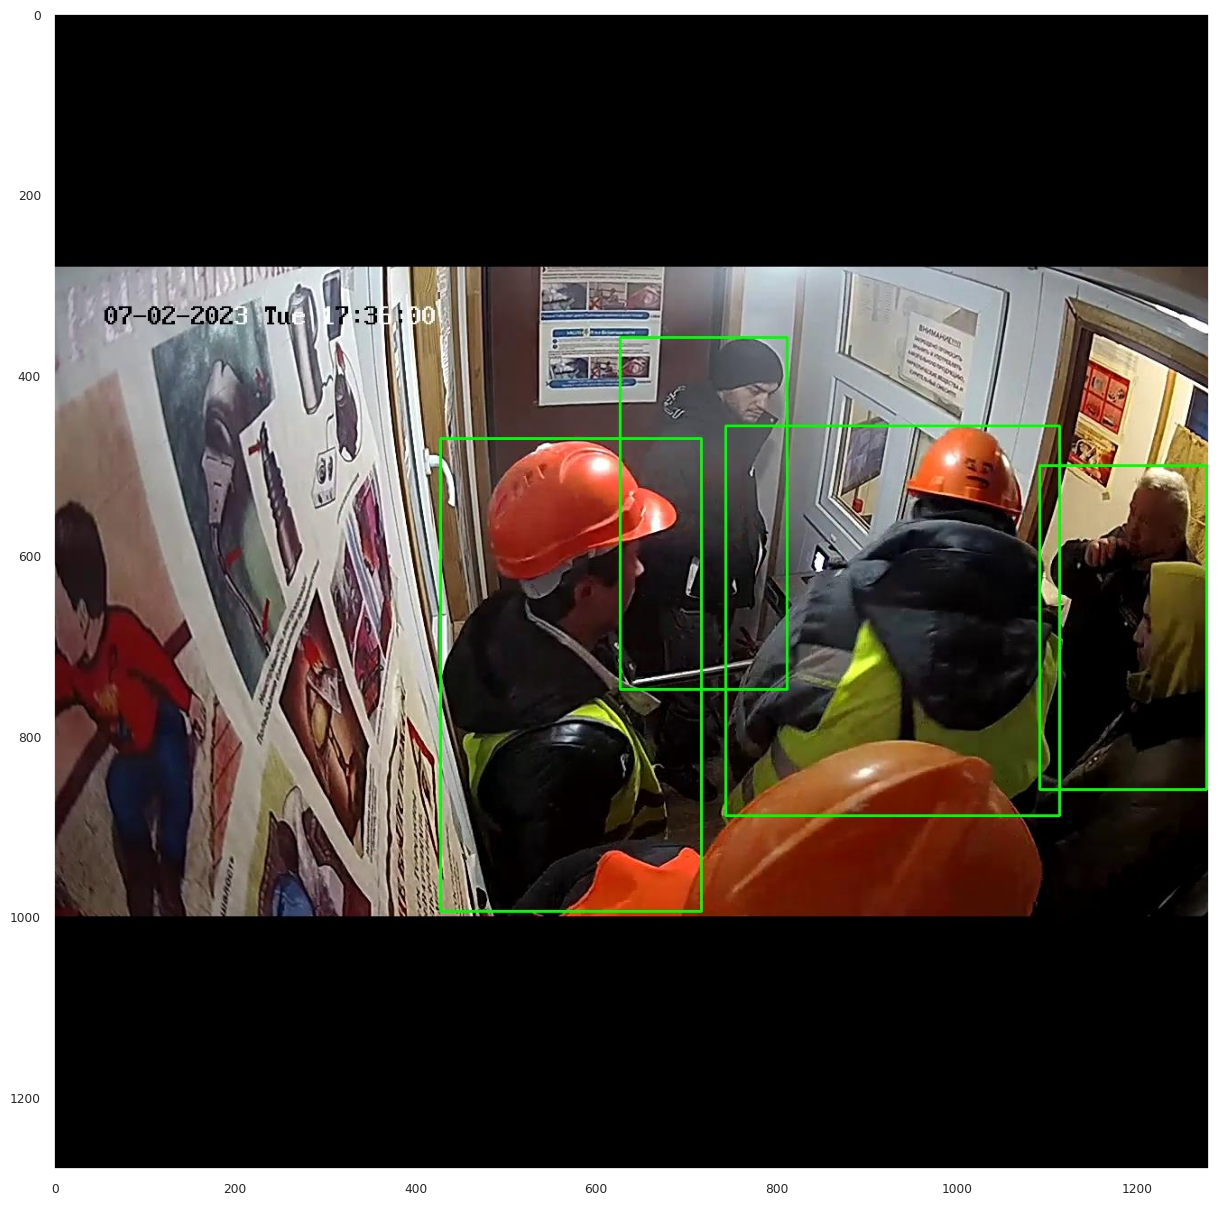


image 1/1 /home/gordondalos/Документы/Университет/ai-universitet/practica/4154.jpg: 640x640 3 persons, 30.7ms
Speed: 0.4ms preprocess, 30.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


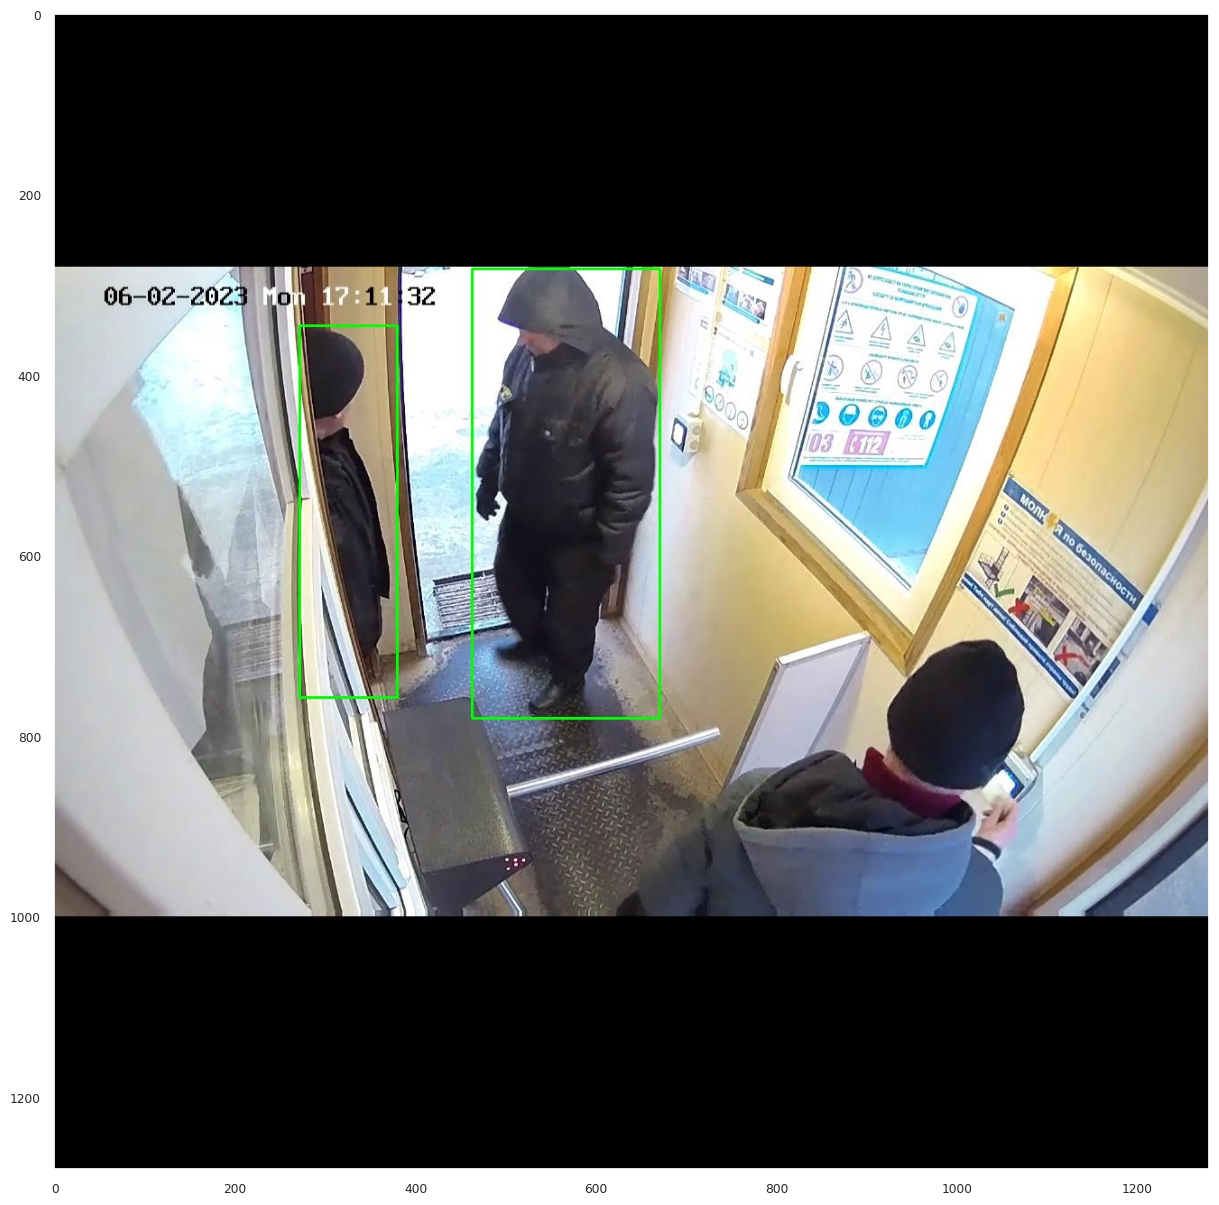


image 1/1 /home/gordondalos/Документы/Университет/ai-universitet/practica/4113.jpg: 640x640 1 person, 27.6ms
Speed: 0.4ms preprocess, 27.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


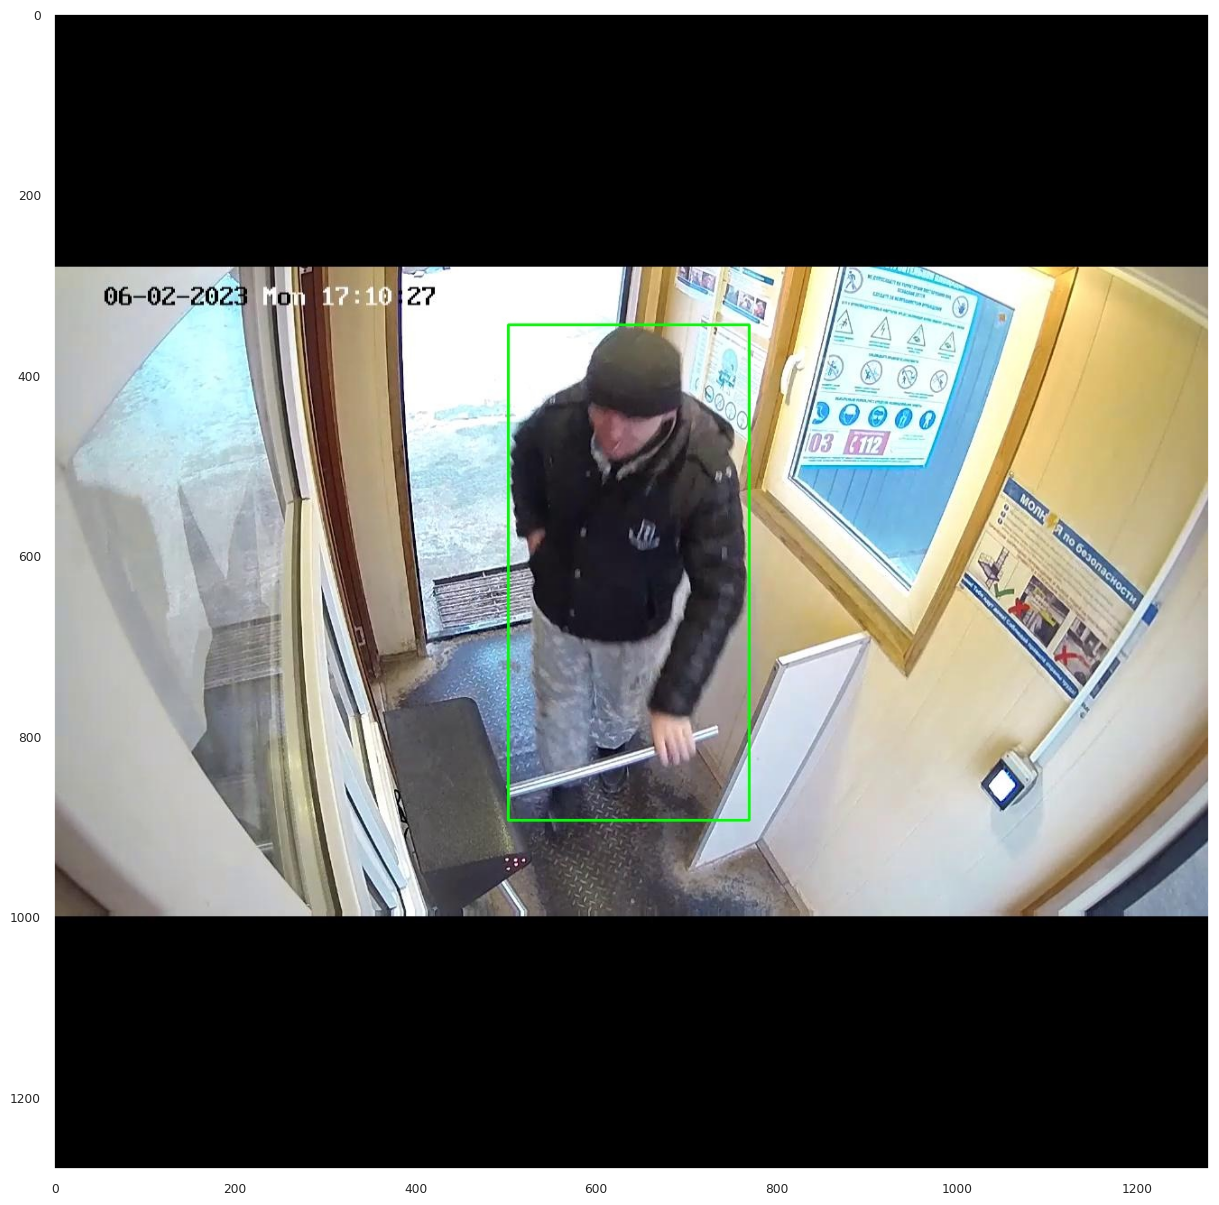


image 1/1 /home/gordondalos/Документы/Университет/ai-universitet/practica/5936.jpg: 640x640 1 person, 29.0ms
Speed: 0.7ms preprocess, 29.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


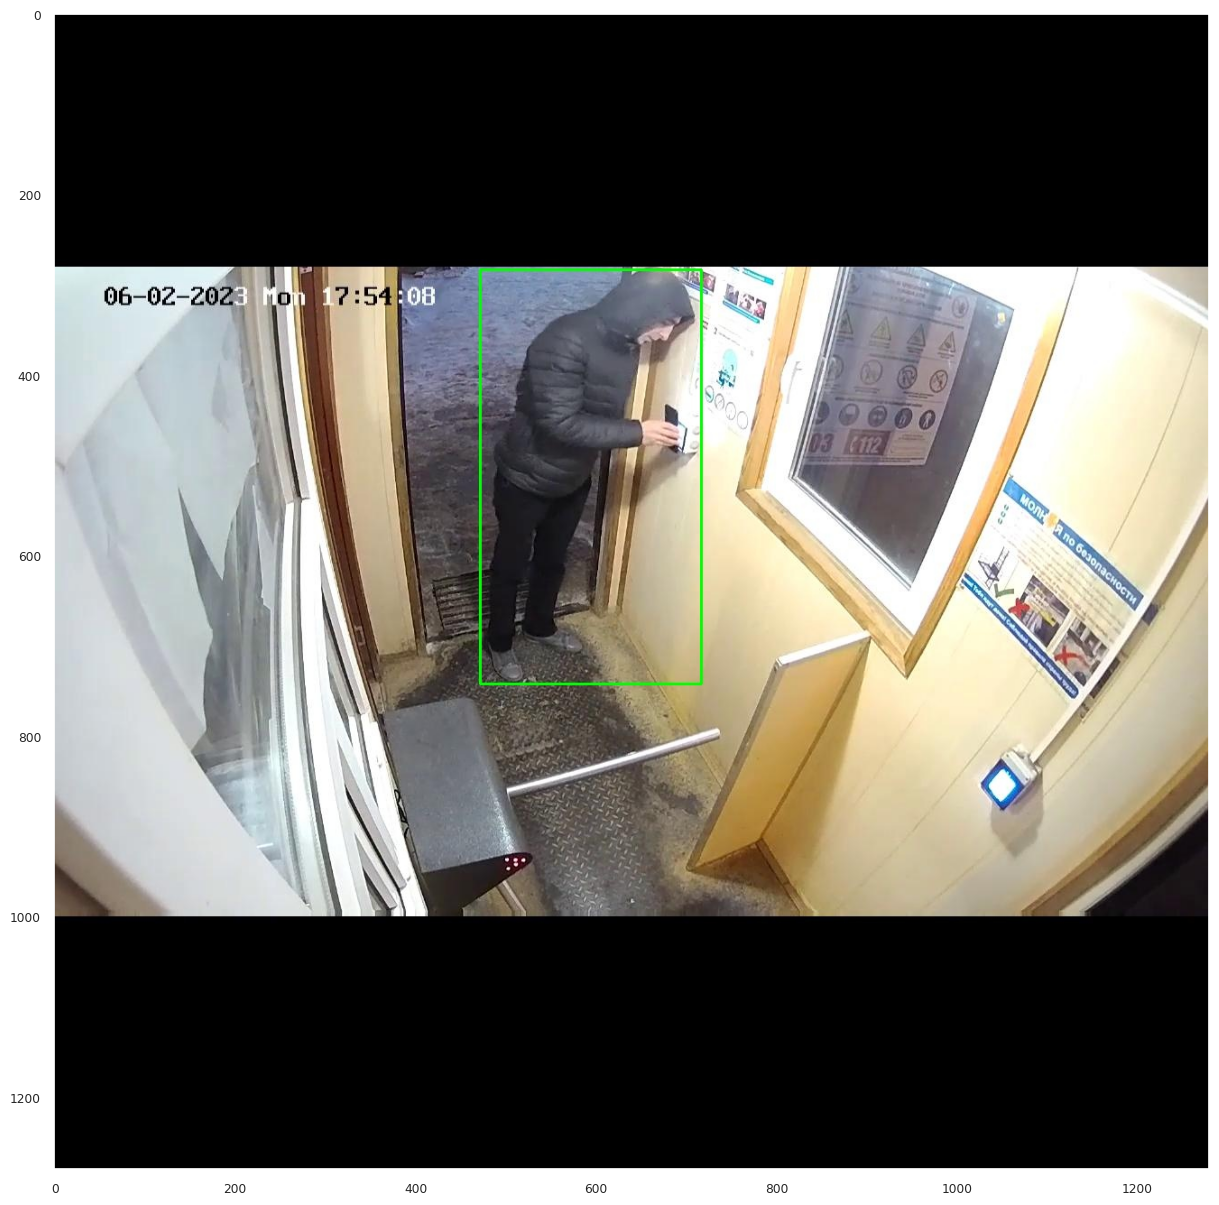

In [8]:
result_and_show("./photo_2023-02-19_20-05-10.jpg", model)
result_and_show("./4154.jpg", model)
result_and_show("./4113.jpg", model)
result_and_show("./5936.jpg", model)

In [53]:
from skimage.metrics import structural_similarity as compare_ssim


def getSSIM(image, image2):
    # Структурный индекс сходства (SSIM) - это метод,
    # который пытается измерить схожесть между двумя изображениями
    # с учетом их структуры и восприятия человеком.
    img1_resized = cv2.resize(image, (image2.shape[1], image2.shape[0]))

    gray_image = cv2.cvtColor(img1_resized, cv2.COLOR_BGR2GRAY)
    gray_image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    ssim = compare_ssim(gray_image, gray_image2)
    return ssim

In [104]:
def getHistDistance(image, image2):
    # рассчитываем гистограммы цветов для обоих изображений
    hist, _ = np.histogram(image, bins=256, range=(0, 255))
    hist2, _ = np.histogram(image2, bins=256, range=(0, 255))

    # рассчитываем расстояние Хэмминга между гистограммами // пробовал мало информативное
    # hamming_distance = np.count_nonzero(hist != hist2)
    # return hamming_distance

    return np.max(np.abs(hist - hist2)) # Расстояние Чебышева
    # return np.sqrt(np.sum((hist - hist2) ** 2)) # Расстояние Евклидово
    # return  np.sqrt(np.sum((np.sqrt(hist) - np.sqrt(hist2)) ** 2)) / np.sqrt(2) # Расстояние Хелингера




In [96]:
# Попробуем получить хеши изображений для того чтобы сравнить эти изображения между собой

def average_hash(image_path, hash_size=8):
    # Открываем изображение и преобразуем его в оттенки серого
    image = Image.open(image_path).convert('L')
    # Изменяем размер изображения
    image = image.resize((hash_size, hash_size), Image.ANTIALIAS)
    # Преобразуем изображение в массив NumPy
    pixels = np.asarray(image)
    # Вычисляем среднее значение яркости пикселей
    avg = pixels.mean()
    # Превращаем массив пикселей в бинарный массив на основе среднего значения
    diff = pixels > avg
    # Преобразуем бинарный массив в целочисленный хеш
    bit_string = ''.join('1' if b else '0' for b in diff.flatten())

    return int(bit_string, 2)


def normalized_hamming_distance(hash1, hash2, hash_size=64):
    """
    Вычисление Normalized Hamming Distance между двумя хешами
    """
    hamming_distance = bin(hash1 ^ hash2).count('1')
    return hamming_distance / hash_size


def similarity_percentage(hash1, hash2, hash_size=64):
    """
    Вычисление процента совпадения хешей
    """
    normalized_distance = normalized_hamming_distance(hash1, hash2, hash_size)
    return (1 - normalized_distance) * 100

In [97]:
def getPNSR(url, url2):
    #Peak Signal-to-Noise Ratio (PSNR) - это метрика, которая измеряет среднеквадратичное отклонение между двумя изображениями.
    image = cv2.imread(url)
    image2 = cv2.imread(url2)
    img1_resized = cv2.resize(image, (image2.shape[1], image2.shape[0]))
    psnr = cv2.PSNR(img1_resized, image2)
    return psnr

In [98]:
def getMSE(url, url1):
    image = cv2.imread(url)
    image2 = cv2.imread(url1)
    img1_resized = cv2.resize(image, (image2.shape[1], image2.shape[0]))
    mse = np.mean((img1_resized - image2) ** 2)
    return mse

In [99]:
# проверим все функции на работоспособность
def compare_image(url, url1, showImage=False):
    image = cv2.imread(url)
    image2 = cv2.imread(url1)
    ssim = getSSIM(image, image2)
    histDitance = getHistDistance(image, image2)
    hash = average_hash(url)
    hash2 = average_hash(url1)
    n_hamming_distance = normalized_hamming_distance(hash, hash2)
    hashPercent = similarity_percentage(hash, hash2)
    pnsr = getPNSR(url, url1)
    mse = getMSE(url, url1)
    if showImage:
        show_image_by_url(url, 6, 4)
        show_image_by_url(url1, 6, 4)
        print('url', url)
        print('url1', url1)
        print('ssim', ssim)
        print('pnsr', pnsr)
        print('mse', mse)
        print('histDitance', histDitance)
        print('n_hamming_distance', n_hamming_distance)
        print('hash', hash)
        print('hashPercent', hashPercent)

    return ssim, pnsr, mse, histDitance, n_hamming_distance, hash, hashPercent


In [100]:

url = './data_test/4113.jpg'
url1 = './data_test/4154.jpg'
compare_image(url, url1, True)

In [60]:
url = './data_test/235.jpg'
url1 = './data_test/240.jpg'
compare_image(url, url1)

/tmp/ipykernel_57138/1895106265.py:7: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize((hash_size, hash_size), Image.ANTIALIAS)


(0.8158800932151812,
 17.379382176365343,
 51.2561279296875,
 256,
 0.0,
 281468475015168,
 100.0)

/tmp/ipykernel_57138/1895106265.py:7: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize((hash_size, hash_size), Image.ANTIALIAS)


url ./data_test/221.jpg
url1 ./data_test/5936.jpg


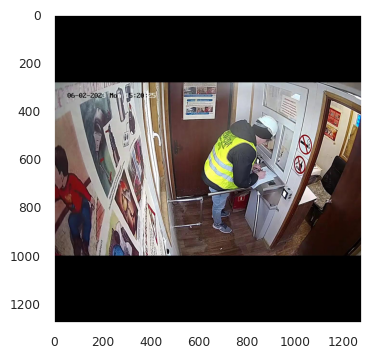

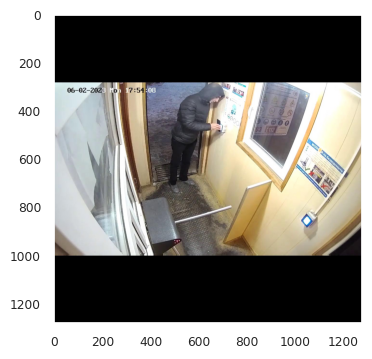

ssim 0.572561522696051
pnsr 10.240329337719071
mse 59.86405680338542
histDitance 256
n_hamming_distance 1.125
hash 281474950758400
hashPercent -12.5


(0.572561522696051,
 10.240329337719071,
 59.86405680338542,
 256,
 1.125,
 281474950758400,
 -12.5)

In [61]:
url = './data_test/221.jpg'
url1 = './data_test/5936.jpg'
compare_image(url, url1, True)

In [62]:
def getCrop(url, bbox):
    import cv2
    import random
    import string
    image = cv2.imread(url)
    x, y, w, h, conf, cls = map(int, bbox)
    crop = image[y:h, x:w]
    random_string = ''.join(random.choices(string.ascii_letters + string.digits, k=5))
    cropUrl = f'./crop/{url.split("/")[2].split(".")[0]}-{random_string}.jpg'
    cv2.imwrite(cropUrl, crop)
    return cropUrl


In [63]:
def getCenterAndPosition(bbox):
    import math
    x1, y1, x2, y2, conf, cls = bbox.tolist()
    # находим центр баудинг бокса
    center_x = (x1 + x2) / 2
    center_y = (y1 + y2) / 2
    # Находим вектора позиции центра  - при условии что 640 на 640 это размер фото
    # Вектор A  - расстояние между началом координат 0 - 0 до центра ббокса
    # Вектор B  - расстояние между началом координат 0 - 640 до центра ббокса
    # Вектор C  - расстояние между началом координат 640 - 640 до центра ббокса
    # Вектор D  - расстояние между началом координат 640 - 0 до центра ббокса

    ax = 0
    ay = 0
    a = math.sqrt((center_x - ax)**2 + (center_y - ay)**2)

    bx = 0
    by = 0
    b = math.sqrt((center_x - bx)**2 + (center_y - by)**2)

    cx = 0
    cy = 0
    c = math.sqrt((center_x - cx)**2 + (center_y - cy)**2)

    dx = 0
    dy = 0
    d = math.sqrt((center_x - dx)**2 + (center_y - dy)**2)

    return center_x, center_y, a, b, c, d

In [91]:
def draw_new_row(url, bbox):
    x, y, w, h, conf, cls = map(int, bbox)
    cropUrl = getCrop(url, bbox.tolist())
    center_x, center_y, a, b, c, d = getCenterAndPosition(bbox)

    new_row = {
        'file_name': cropUrl,
        'center_x': center_x,
        'center_y': center_y,
        'a': a,
        'b': b,
        'c': c,
        'd': d,
        'x': x,
        'y': y,
        'w': w,
        'h': h,
        'ssim': None,
        'pnsr': None,
        'mse': None,
        'histDitance': None,
        'n_hamming_distance': None,
        'hash': None,
        'hashPercent': None,
        'previous_cropUrl': None,
    }

    return new_row, cropUrl


In [102]:
import re
def drawDf(path, dfName, model):
    previous_cropUrl = ''
    pattern = re.compile(r'\d+')
    df = pd.DataFrame(columns=[
        'file_name', 'center_x', 'center_y',
        'a', 'b', 'c', 'd',
        'x', 'y', 'w', 'h',
        'ssim', 'pnsr', 'mse',
        'histDitance','n_hamming_distance', 'hash', 'hashPercent',
        'previous_cropUrl'
    ])
    for root, dirs, files in os.walk(path):
        sorted_file_list = sorted(files, key=lambda x: int(pattern.findall(x)[0]))
        for file in sorted_file_list:
            if file.endswith(('.jpg', '.png')):
                url = os.path.join(root, file)
                print(url)
                results = model(url)
                if results and results[0] and results[0].boxes:
                    for boxes in results[0].boxes:
                        for bbox in boxes.boxes:
                            x, y, w, h, conf, cls = map(int, bbox)  # Фильтруем только людей
                            if model.names[int(cls)] == 'person':  # Фильтруем только людей
                                new_row, cropUrl = draw_new_row(url, bbox)

                                image = cv2.imread(cropUrl)

                                if 'previous_image' in locals() and 'previous_cropUrl' in locals():
                                    ssim, pnsr, mse, histDitance, n_hamming_distance, hash, hashPercent = compare_image(
                                        cropUrl, previous_cropUrl)

                                else:
                                    ssim, pnsr, mse, histDitance, n_hamming_distance, hash, hashPercent = compare_image(
                                        cropUrl, cropUrl)

                                new_row['ssim']=ssim
                                new_row['pnsr']=pnsr
                                new_row['mse']=mse
                                new_row['histDitance']=histDitance
                                new_row['n_hamming_distance']=n_hamming_distance
                                new_row['hash']=hash
                                new_row['hashPercent']=hashPercent

                                if previous_cropUrl :
                                    new_row['previous_cropUrl'] = previous_cropUrl
                                else:
                                    new_row['previous_cropUrl'] = cropUrl

                                df = df.append(new_row, ignore_index=True)

                                previous_image = image;
                                previous_cropUrl = cropUrl;

    df.to_csv(f'{dfName}.csv', index=False)

In [105]:
path = './data_test'
drawDf(path, 'test', model)

In [106]:
path = './data_image'
drawDf(path, 'croped_all_df', model); # точка с запятой в конце строки подавляет вывод